In [1]:
# Mount Google Drive
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
DATA_LOC = "/content/drive/MyDrive/Rhexis/datasets/test_pulls"
REPO_LOC = "/content/drive/MyDrive/Trajectories/rhexis-trajectory"

In [3]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

sys.path.insert(0, f"{REPO_LOC}/Trajectory_Classification")
from utils import *

%load_ext autoreload
%autoreload 2

## Logistic Regression

In [4]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(random_state=0, max_iter=1000)
param_grid = {
    "pca__n_components": list(range(3, 20)),
}
bin_grid = list(range(5, 25))
results_lr = grid_search_with_bins(make_custom_pipeline(clf_lr, True), param_grid, bin_grid)

/content/drive/MyDrive/Trajectories/rhexis-trajectory/Trajectory_Classification/utils.py:192: RuntimeWarning: invalid value encountered in double_scalars
  angle_nocos = np.dot(v1, v2) / (np.linalg.norm(v1, 2) * np.linalg.norm(v2, 2))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
45 fits failed out of a total of 85.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 390, in fi

21


/content/drive/MyDrive/Trajectories/rhexis-trajectory/Trajectory_Classification/utils.py:192: RuntimeWarning: invalid value encountered in double_scalars
  angle_nocos = np.dot(v1, v2) / (np.linalg.norm(v1, 2) * np.linalg.norm(v2, 2))


In [5]:
results_lr["best_score"]

0.8857142857142858

In [6]:
results_lr["best_params"]

{'data__n_bins': 21, 'pca__n_components': 9}

In [7]:
results_lr["best_search"].score(results_lr["X_test"], results_lr["y_test"])

0.7777777777777778

## Quadratic Gaussian Discriminant Analysis

In [8]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

clf_qda = QuadraticDiscriminantAnalysis()
param_grid = {
    "pca__n_components": list(range(3, 20)),
    "quadraticdiscriminantanalysis__reg_param": [
        1e-6,
        1e-3,
        1e-2,
        1e-1,
        2e-1,
        3e-1,
        4e-1,
        5e-1,
    ],
}
bin_grid = list(range(5, 25))
results_qda = grid_search_with_bins(clf_qda, param_grid, bin_grid)

/content/drive/MyDrive/Trajectories/rhexis-trajectory/Trajectory_Classification/utils.py:192: RuntimeWarning: invalid value encountered in double_scalars
  angle_nocos = np.dot(v1, v2) / (np.linalg.norm(v1, 2) * np.linalg.norm(v2, 2))
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variab

6


/content/drive/MyDrive/Trajectories/rhexis-trajectory/Trajectory_Classification/utils.py:192: RuntimeWarning: invalid value encountered in double_scalars
  angle_nocos = np.dot(v1, v2) / (np.linalg.norm(v1, 2) * np.linalg.norm(v2, 2))


In [9]:
results_qda["best_score"]

0.8714285714285713

In [10]:
results_qda["best_params"]

{'data__n_bins': 6,
 'pca__n_components': 7,
 'quadraticdiscriminantanalysis__reg_param': 0.4}

In [11]:
results_qda["best_search"].score(results_qda["X_test"], results_qda["y_test"])

0.7222222222222222

## Multi-Layer Perceptron

From above experiments, we are sure that 21 bins is the optimal amount, and do not need to grid search over that parameter any further.

In [12]:
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = get_data_for_fixed_bins(21)

clf_mlp = MLPClassifier(
    solver="adam", alpha=1e-5, hidden_layer_sizes=(1000, 1000, 1000), random_state=1
)
param_grid = {
    "pca__n_components": list(range(10, 15)),
    "mlpclassifier__learning_rate_init": [1e-9, 1e-6, 1e-3, 1e-2, 1e-1],
}
search = grid_search(clf_mlp, param_grid, X_train, y_train)

/content/drive/MyDrive/Trajectories/rhexis-trajectory/Trajectory_Classification/utils.py:192: RuntimeWarning: invalid value encountered in double_scalars
  angle_nocos = np.dot(v1, v2) / (np.linalg.norm(v1, 2) * np.linalg.norm(v2, 2))
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_mul

In [13]:
search.best_score_

0.8285714285714286

In [14]:
search.best_params_

{'mlpclassifier__learning_rate_init': 1e-06, 'pca__n_components': 13}

In [15]:
search.score(X_test, y_test)

0.7222222222222222

## Histogram-based Gradient Boosting (LightGBM)

In [16]:
from sklearn.ensemble import HistGradientBoostingClassifier

X_train, X_test, y_train, y_test = get_data_for_fixed_bins(21)

clf_hgbc = HistGradientBoostingClassifier()
param_grid = {
    "pca__n_components": [10],
    "histgradientboostingclassifier__loss": ['log_loss', 'binary_crossentropy'],
    "histgradientboostingclassifier__learning_rate": [1e-9, 1e-6, 1e-3, 1e-2, 1e-1],
    "histgradientboostingclassifier__min_samples_leaf": list(range(5, 20)),
    "histgradientboostingclassifier__l2_regularization": [0, 1e-9, 1e-6, 1e-3, 1e-2, 0.1, 0.2, 0.3, 0.5, 0.75]
    
}
hgbc_search = grid_search(clf_hgbc, param_grid, X_train, y_train)

/content/drive/MyDrive/Trajectories/rhexis-trajectory/Trajectory_Classification/utils.py:192: RuntimeWarning: invalid value encountered in double_scalars
  angle_nocos = np.dot(v1, v2) / (np.linalg.norm(v1, 2) * np.linalg.norm(v2, 2))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3750 fits failed out of a total of 7500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3750 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394

In [17]:
hgbc_search.best_score_

0.8714285714285716

In [18]:
hgbc_search.best_params_

{'histgradientboostingclassifier__l2_regularization': 0.3,
 'histgradientboostingclassifier__learning_rate': 0.01,
 'histgradientboostingclassifier__loss': 'binary_crossentropy',
 'histgradientboostingclassifier__min_samples_leaf': 9,
 'pca__n_components': 10}

In [19]:
hgbc_search.score(X_test, y_test)

0.8888888888888888

## Generate ROC Curves for Logistic Regression, Quadratic GDA, and Multilayer Perceptron, HBGB

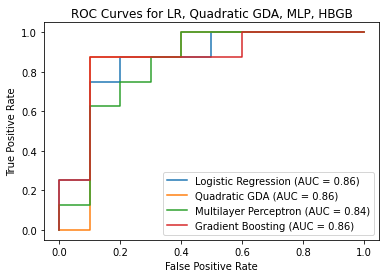

In [20]:
from sklearn.metrics import RocCurveDisplay

# Logistic Regression
lr_best_n_bins = results_lr['best_params']['data__n_bins']
best_clf_lr = results_lr['results'][lr_best_n_bins].best_estimator_
fig = RocCurveDisplay.from_estimator(best_clf_lr, results_lr['X_test'], results_lr['y_test'], name="Logistic Regression")

# Quadratic GDA
qda_best_n_bins = results_qda['best_params']['data__n_bins']
best_clf_qda = results_qda['results'][qda_best_n_bins].best_estimator_
RocCurveDisplay.from_estimator(best_clf_qda, results_qda['X_test'], results_qda['y_test'], name="Quadratic GDA", ax=fig.ax_)

# Multilayer Perceptron
best_clf_mlp = search.best_estimator_
RocCurveDisplay.from_estimator(best_clf_mlp, X_test, y_test, name="Multilayer Perceptron", ax=fig.ax_)

# Histogram based Gradient Boosting
best_clf_hbgc = hgbc_search.best_estimator_
RocCurveDisplay.from_estimator(best_clf_hbgc, X_test, y_test, name="Gradient Boosting", ax=fig.ax_)

plt.title("ROC Curves for LR, Quadratic GDA, MLP, HBGB")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig('ROC_Curves.pdf', dpi=120)

## Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)
clf_rf.score(X_test, y_test)


0.7222222222222222

In [22]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(70, 27)
(18, 27)
(70,)
(18,)


# Evaluate model performance on Final Test Set (manually labeled pulls)

In [23]:
# Load in all pulls
X_train, y_train = get_data_for_fixed_bins(21, split_data = False)

/content/drive/MyDrive/Trajectories/rhexis-trajectory/Trajectory_Classification/utils.py:192: RuntimeWarning: invalid value encountered in double_scalars
  angle_nocos = np.dot(v1, v2) / (np.linalg.norm(v1, 2) * np.linalg.norm(v2, 2))


In [24]:
# Read in test set data
X_test, y_test = get_data_for_fixed_bins(21, split_data = False, get_manual = True)

/content/drive/MyDrive/Trajectories/rhexis-trajectory/Trajectory_Classification/utils.py:192: RuntimeWarning: invalid value encountered in double_scalars
  angle_nocos = np.dot(v1, v2) / (np.linalg.norm(v1, 2) * np.linalg.norm(v2, 2))


In [33]:
# Use the best parameters
clf_hgbc = HistGradientBoostingClassifier(l2_regularization=.3,learning_rate=.01,loss="binary_crossentropy",min_samples_leaf=9)
pipe = make_custom_pipeline(clf_hgbc, include_pca=True, num_components=10)
pipe.fit(X_train, y_train)
pipe.predict_proba(X_test)

array([[0.81002563, 0.18997437],
       [0.73817242, 0.26182758],
       [0.81002563, 0.18997437],
       [0.83083159, 0.16916841],
       [0.63898185, 0.36101815],
       [0.27866756, 0.72133244],
       [0.36295721, 0.63704279],
       [0.33148384, 0.66851616],
       [0.28922303, 0.71077697]])

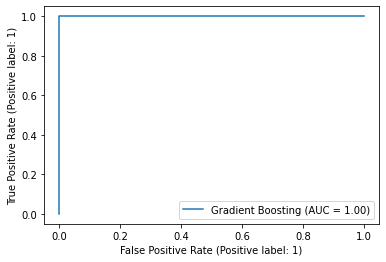

In [31]:
# Determine AUC
fig = RocCurveDisplay.from_estimator(pipe, X_test, y_test, name="Gradient Boosting")
